In [8]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

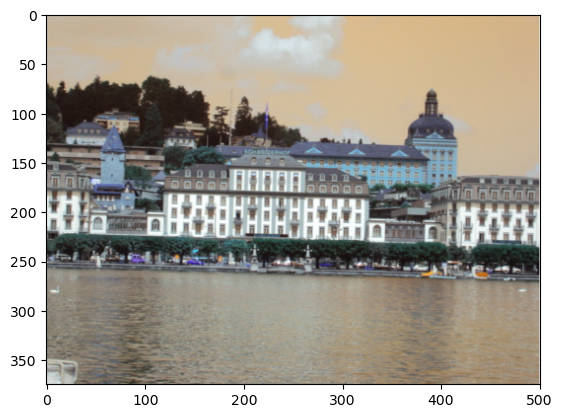

In [9]:
img = cv2.imread("Docs - Primitives-20230926\pics\P1.JPG")

plt.imshow(img)
plt.show()

In [10]:
def harris_corner_detector(image, threshold=0.01, window_size=3, k=0.04, gaus=0):
    # Convert the image to grayscale
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()

    if gaus == 1 :
        
        # Apply Gaussian blurring with
        gray = cv2.GaussianBlur(gray,(window_size,window_size),cv2.BORDER_DEFAULT)
    
    # Compute gradients using Sobel operators
    Ix = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

    height, width = gray.shape
    corner_response = np.zeros((height, width))

    offset = window_size // 2

    for y in range(offset, height - offset):
        for x in range(offset, width - offset):
            # Compute the structure tensor M for the current pixel
            M = np.zeros((2, 2))
            for i in range(-offset, offset + 1):
                for j in range(-offset, offset + 1):
                    Ix_val = Ix[y + i, x + j]
                    Iy_val = Iy[y + i, x + j]
                    M[0, 0] += Ix_val ** 2
                    M[0, 1] += Ix_val * Iy_val
                    M[1, 0] += Ix_val * Iy_val
                    M[1, 1] += Iy_val ** 2

            # Compute the corner response using the Harris formula
            det_M = np.linalg.det(M)
            trace_M = np.trace(M)
            corner_response[y, x] = det_M - k * (trace_M ** 2)

    # Threshold the corner response to identify significant corners
    corners = np.zeros_like(image)
    corners[corner_response > threshold * corner_response.max()] = [255, 0, 0]  # Mark corners in red

    return corners, corner_response

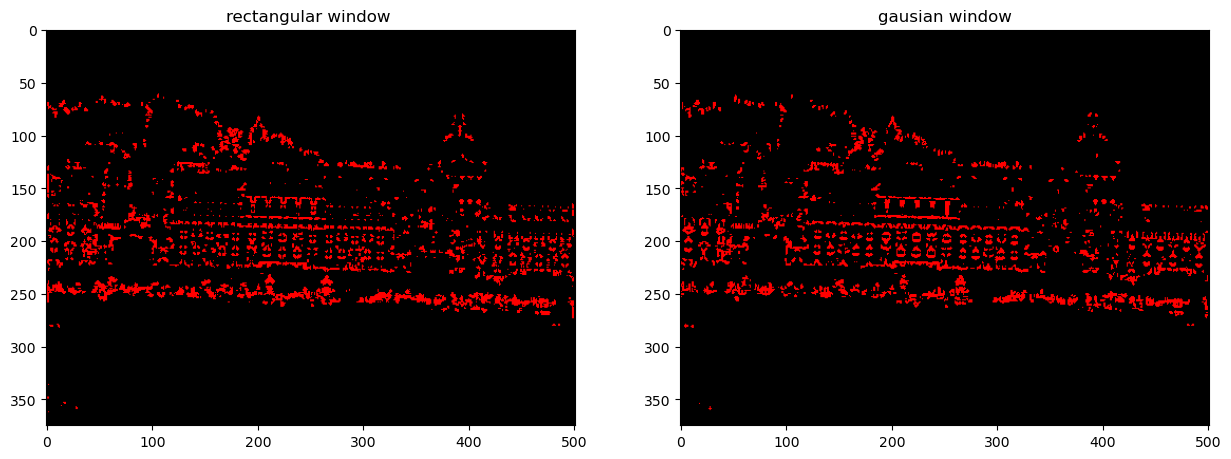

In [18]:
# Detect corners using the Harris Corner Detector whith rectangular window 
corner_image_1, corner_response_1 = harris_corner_detector(img, threshold=0.01, window_size=3, k=0.04,gaus = 0)

# Detect corners using the Harris Corner Detector with gausian window
corner_image_2, corner_response_2 = harris_corner_detector(img, threshold=0.01, window_size=3, k=0.04,gaus = 1)

plt.figure(figsize=(15, 10))

# rectangular window
plt.subplot(1,2,1)
plt.imshow(corner_image_1)
plt.title("rectangular window ")

# gausian window
plt.subplot(1,2,2)
plt.imshow(corner_image_2)
plt.title("gausian window")

plt.show()

## implimeting the Harris corners detector using cv2 


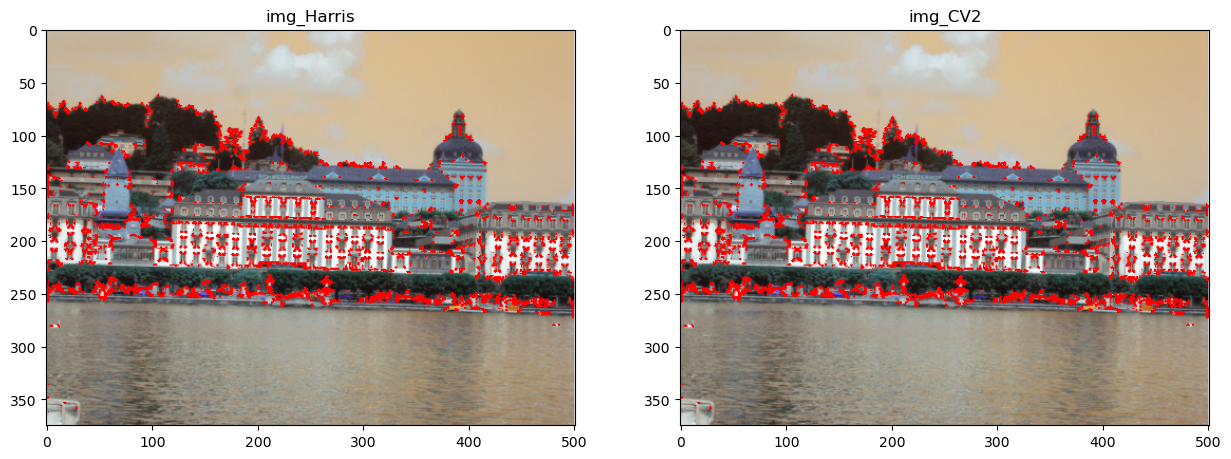

In [12]:
# Convert the image to grayscale (Harris detector works on grayscale images)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Perform Harris Corner Detection
dst = cv2.cornerHarris(gray, blockSize=3, ksize=3, k=0.04)

# Threshold the corner response to identify significant corners
threshold = 0.01 * dst.max()
corner_image_dts = np.zeros_like(img)
corner_image_dts[dst > threshold] = [255, 0, 0]  # Mark corners in red

# Display the corners on the original image
plt.figure(figsize=(15, 10))

# Harris
plt.subplot(1,2,1)
img_Harris = img.copy()
img_Harris[corner_response_1 > 0.01 * corner_response_1.max()] = [255,0,0]
plt.imshow(img_Harris)
plt.title("img_Harris")

# CV2
plt.subplot(1,2,2)
img_CV2 = img.copy()
img_CV2[dst > 0.01 * dst.max()] = [255,0,0]
plt.imshow(img_CV2)
plt.title("img_CV2")

plt.show()

## remouving local minimums 

In [13]:
def RLM(corner_response, WL=5):
    height, width = corner_response.shape

    offset = WL //2

    for i in range(offset, height-offset) :
        for j in range(offset, width-offset) : 
            if corner_response[i,j] < corner_response[i-offset:i+offset+1,j-offset:j+offset+1].max() :
                corner_response[i,j] = 0

    return corner_response

Text(0.5, 1.0, 'img_Harris')

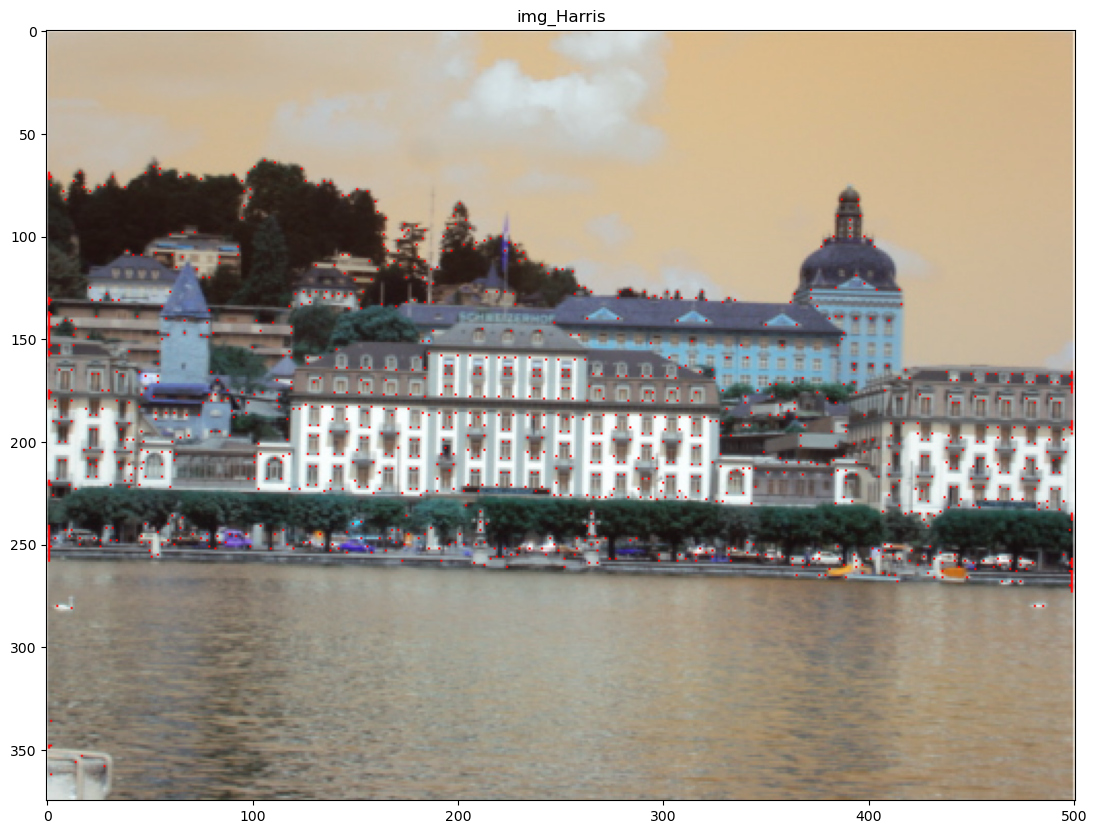

In [14]:
corner_response_rlm = RLM(corner_response_1)
plt.figure(figsize=(15, 10))
img_Harris = img.copy()
img_Harris[corner_response_rlm > 0.01 * corner_response_rlm.max()] = [255,0,0]
plt.imshow(img_Harris)
plt.title("img_Harris")

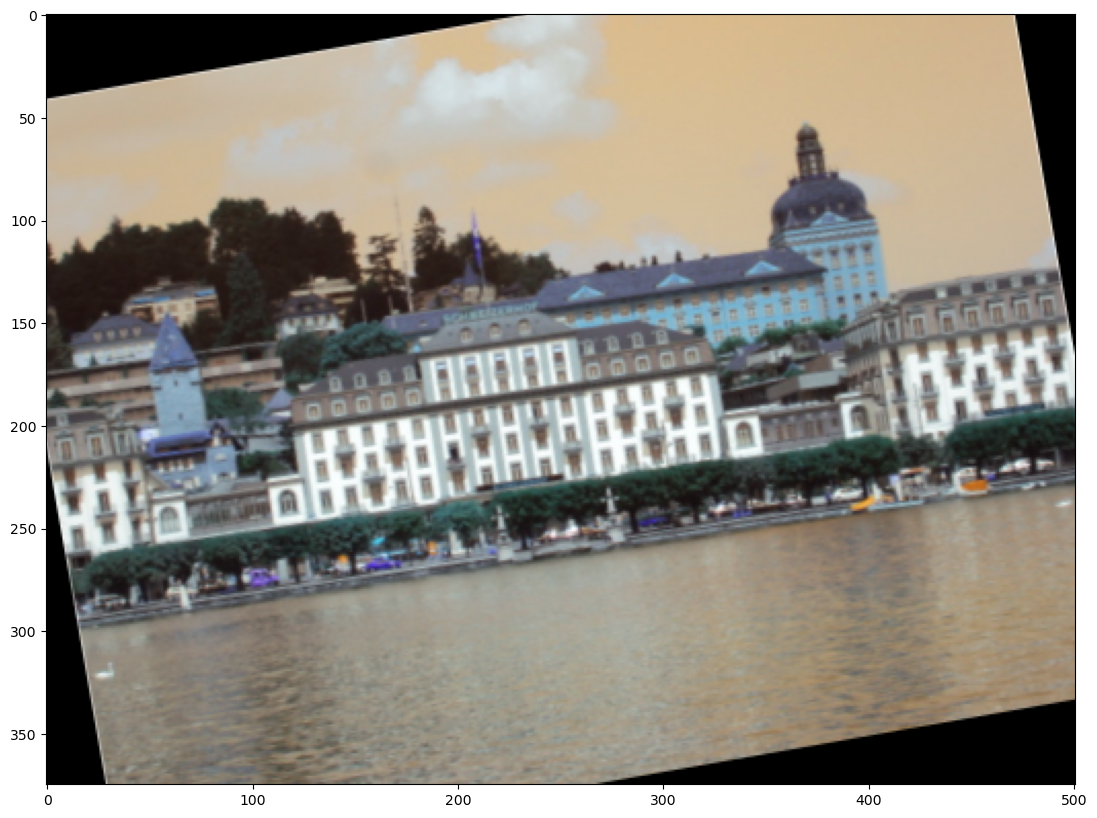

In [15]:
angle = 10  # Adjust the angle as needed

# Get the image dimensions
height, width = img.shape[:2]

# Calculate the rotation matrix
rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)

# Perform the rotation
rotated_image = cv2.warpAffine(img, rotation_matrix, (width, height))

plt.figure(figsize=(15, 10))
plt.imshow(rotated_image)


Text(0.5, 1.0, 'rotated img')

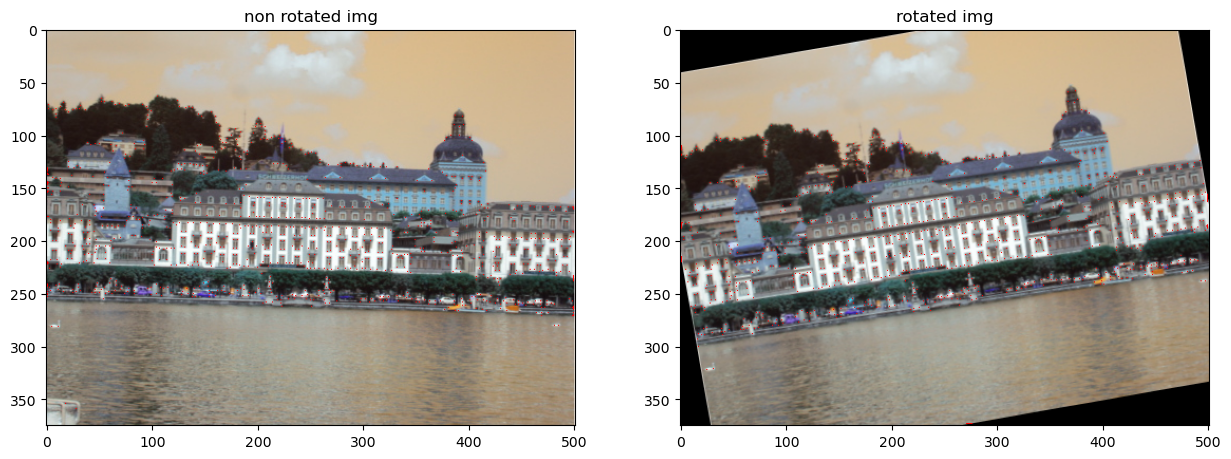

In [23]:
corner_image_1, corner_response_1 = harris_corner_detector(img, threshold=0.01, window_size=3, k=0.04,gaus = 1)

corner_image_2, corner_response_2 = harris_corner_detector(rotated_image, threshold=0.01, window_size=3, k=0.04,gaus = 1)

plt.figure(figsize=(15, 10))

plt.subplot(1,2,1)
corner_response_rlm_1 = RLM(corner_response_1)
img_nr = img.copy()
img_nr[corner_response_rlm_1 > 0.01 * corner_response_rlm_1.max()] = [255,0,0]
plt.imshow(img_nr)
plt.title("non rotated img")

# rotated
plt.subplot(1,2,2)
corner_response_rlm_2 = RLM(corner_response_2)
img_r = rotated_image.copy()
img_r[corner_response_rlm_2 > 0.01 * corner_response_rlm_2.max()] = [255,0,0]
plt.imshow(img_r)
plt.title("rotated img")

In [39]:
def Fast(img, threshold=30):
    
    height, width = img.shape
    offset = 3

    corners = np.zeros([height, width])
    
    for x in range(offset, height - offset) : 
        for y in range(offset, width - offset) :
            pixel_intensity = img[x, y]
            
            # Coordinates of the 16 pixels in the Bresenham circle
            offsets = [         (-1, 3),(0, 3),(1, 3),
                        (-2, 2),                      (2, 2), 
                (-3, 1),                                    (3, 1), 
                (-3, 0),                                    (3, 0), 
                (-3,-1),                                    (3,-1), 
                        (-2,-2),                      (2,-2), 
                                (-1,-3),(0,-3),(1,-3)]
            
            brighter = 0
            darker = 0
            
            for i, j in offsets:
                if pixel_intensity + threshold < img[x+i, y+j]:
                    brighter += 1
                elif pixel_intensity - threshold > img[x+i, y+j]:
                    darker += 1
            
            if brighter >= 12 or darker >= 12:
                corners[x, y] = 1
    return corners

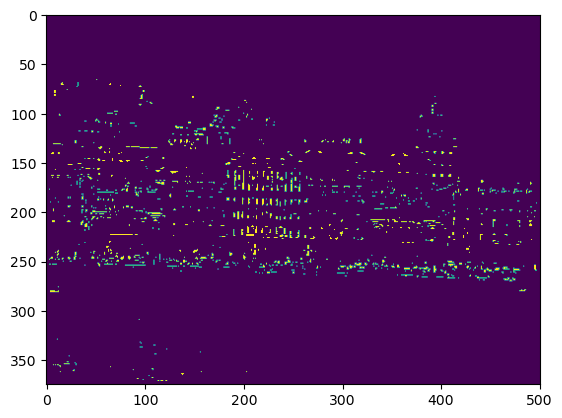

In [41]:
c = Fast(gray)
plt.imshow(c)